Using global choroid band: rows 231 to 287
a_25_1.jpg:
  SNR:  23.88 dB
  PSNR: 34.38 dB
  Choroid Band Thickness: 56 pixels



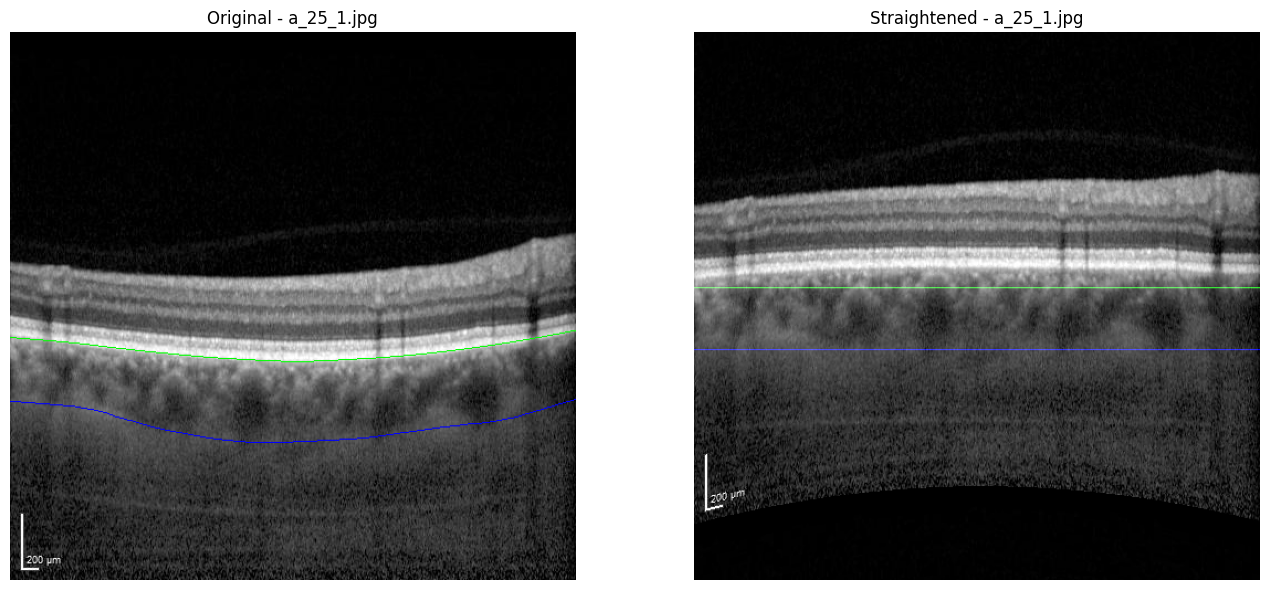

a_25_10.jpg:
  SNR:  26.38 dB
  PSNR: 36.16 dB
  Choroid Band Thickness: 56 pixels



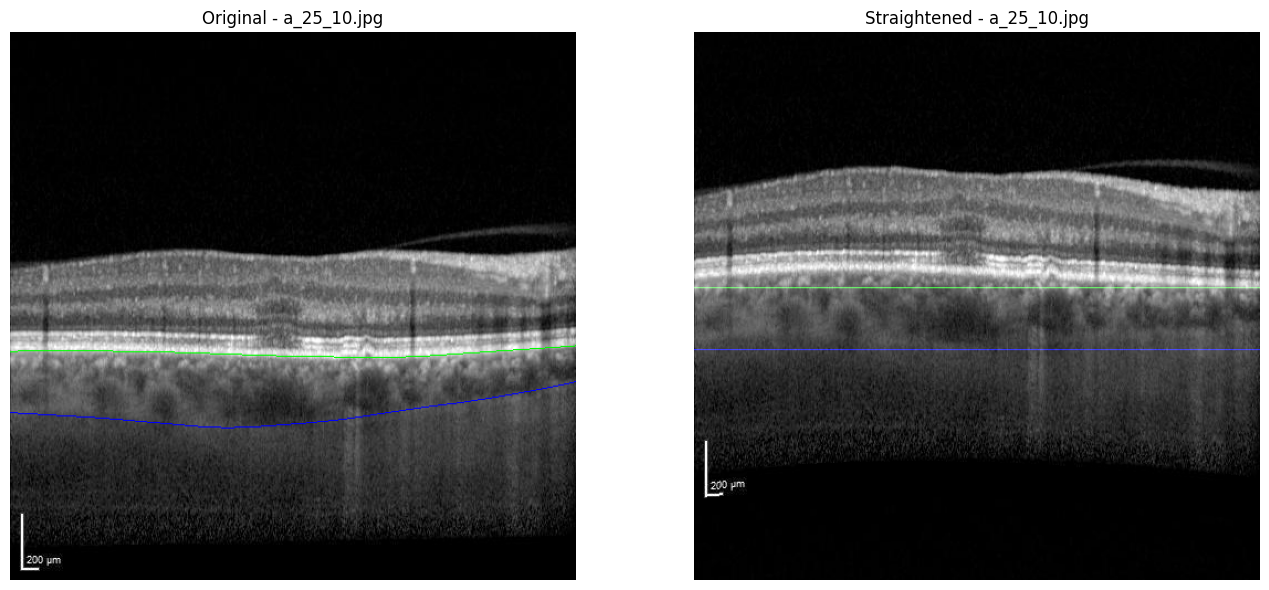

a_25_13.jpg:
  SNR:  25.52 dB
  PSNR: 34.87 dB
  Choroid Band Thickness: 56 pixels



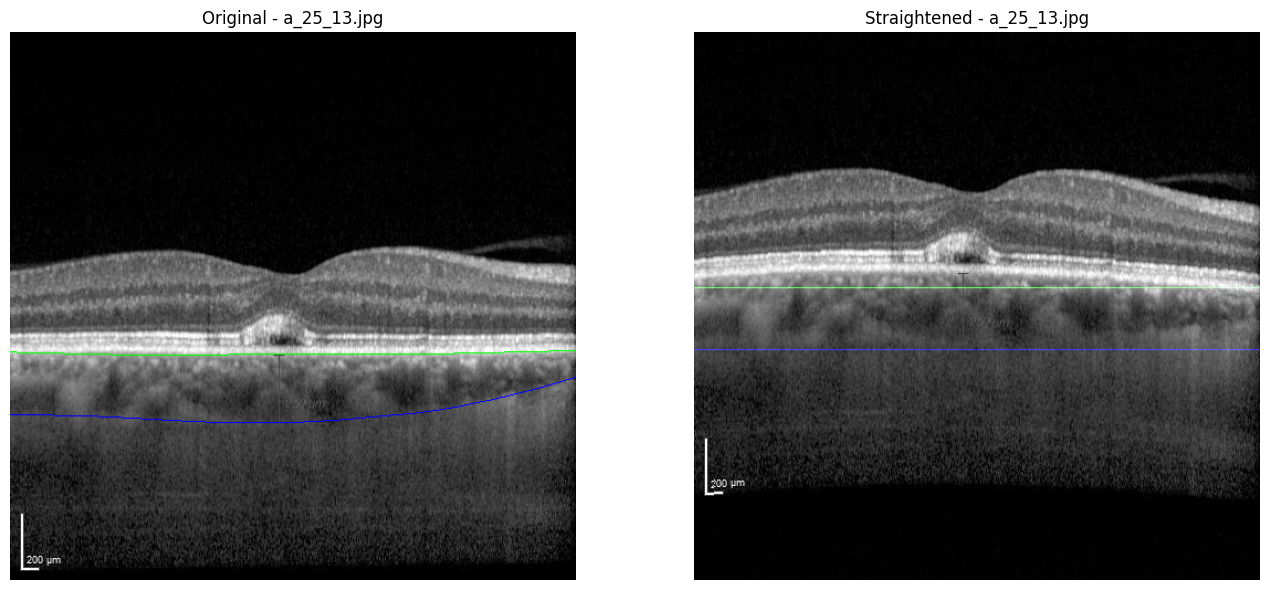

a_25_18.jpg:
  SNR:  25.76 dB
  PSNR: 35.63 dB
  Choroid Band Thickness: 56 pixels



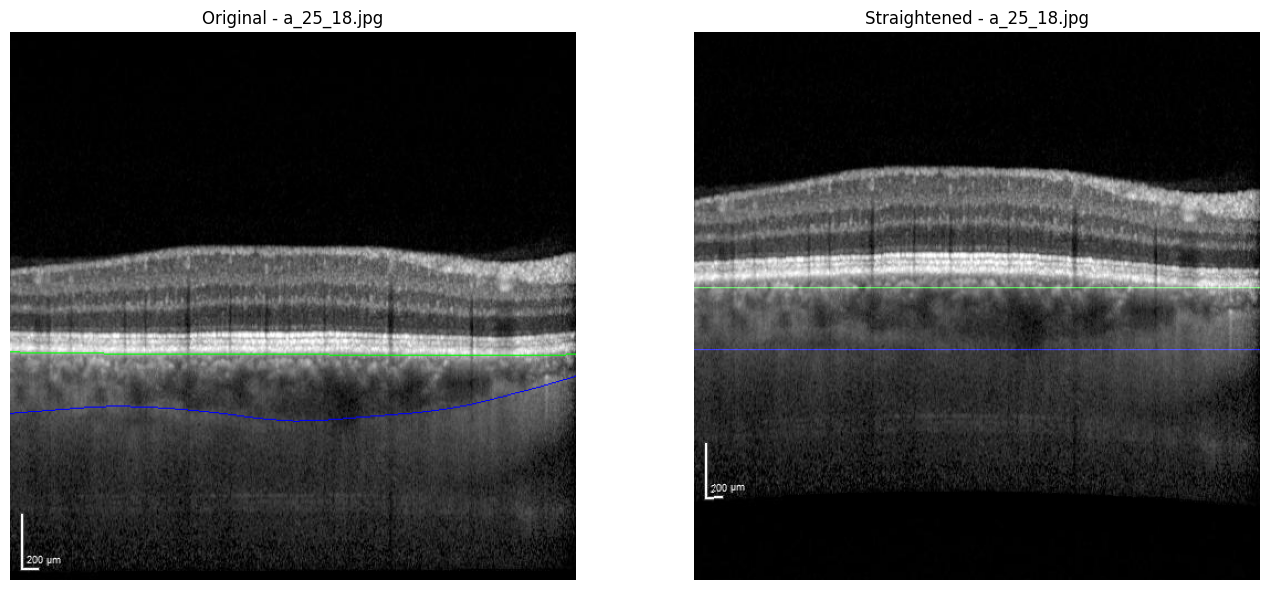

a_25_24.jpg:
  SNR:  27.41 dB
  PSNR: 35.60 dB
  Choroid Band Thickness: 56 pixels



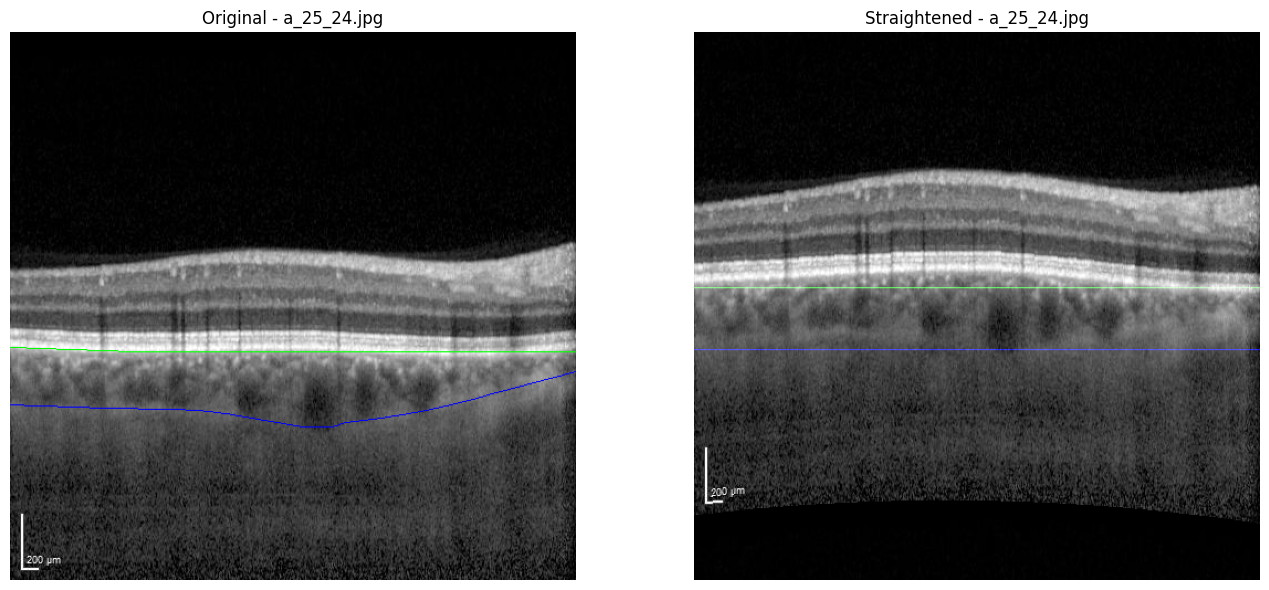

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Directory setup
ROOT = r"/home/msi/Documents/IIT-H/src"
ORG_DIR = os.path.join(ROOT, "training_data", "good_images_all")
GT_MASK_DIR = os.path.join(ROOT, "training_data", "gt_masks_good")

# --- Helpers ---
def get_choroid_edges(mask):
    top_edge = np.argmax(mask, axis=0)
    bottom_edge = mask.shape[0] - np.argmax(np.flipud(mask), axis=0) - 1
    return top_edge, bottom_edge

def straighten_image_using_mask(img, mask, degree=2):
    top, bottom = get_choroid_edges(mask)
    x = np.arange(len(top))
    top_fit = np.polyfit(x, top, degree)
    bottom_fit = np.polyfit(x, bottom, degree)
    top_line = np.polyval(top_fit, x)
    bottom_line = np.polyval(bottom_fit, x)
    center_line = np.mean([top_line, bottom_line], axis=0)
    target_center = img.shape[0] / 2
    shift_amounts = center_line - target_center

    warped_img = np.zeros_like(img)
    warped_mask = np.zeros_like(mask)
    for i in range(img.shape[1]):
        shift = int(round(shift_amounts[i]))
        warped_img[:, i] = np.roll(img[:, i], -shift)
        warped_mask[:, i] = np.roll(mask[:, i], -shift)
    return warped_img, warped_mask

def pad_edge_array(arr, target_len):
    current_len = len(arr)
    if current_len >= target_len:
        return arr[:target_len]
    pad_left = (target_len - current_len) // 2
    pad_right = target_len - current_len - pad_left
    return np.pad(arr, (pad_left, pad_right), mode='reflect')

def compute_global_choroid_band(mask_dir, filenames):
    top_all = []
    bottom_all = []
    widths = []

    for fname in filenames:
        mask_path = os.path.join(mask_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        mask = (mask > 127).astype(np.uint8)
        top, bottom = get_choroid_edges(mask)
        top_all.append(top)
        bottom_all.append(bottom)
        widths.append(len(top))

    if not top_all:
        raise ValueError("No valid masks found.")

    max_width = max(widths)
    top_all_padded = [pad_edge_array(t, max_width) for t in top_all]
    bottom_all_padded = [pad_edge_array(b, max_width) for b in bottom_all]

    top_array = np.stack(top_all_padded)
    bottom_array = np.stack(bottom_all_padded)

    avg_top = int(np.mean(top_array))
    avg_bottom = int(np.mean(bottom_array))
    return avg_top, avg_bottom

def compute_snr_psnr(signal_region, max_val=255):
    denoised = cv2.GaussianBlur(signal_region, (5, 5), 1.0)
    x = signal_region.astype(np.float32).flatten()
    x_hat = denoised.astype(np.float32).flatten()
    power_signal = np.mean(x ** 2)
    mse = np.mean((x - x_hat) ** 2)
    power_noise = mse
    snr = 10 * np.log10(power_signal / (power_noise + 1e-8))
    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-8))
    return snr, psnr

def visualize_original_vs_straightened(original_img, original_mask, straight_img, top, bottom, title_suffix=""):
    top_edge, bottom_edge = get_choroid_edges(original_mask)
    overlay_orig = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    for col in range(overlay_orig.shape[1]):
        if 0 <= top_edge[col] < overlay_orig.shape[0]:
            overlay_orig[top_edge[col], col] = [0, 255, 0]
        if 0 <= bottom_edge[col] < overlay_orig.shape[0]:
            overlay_orig[bottom_edge[col], col] = [0, 0, 255]
    overlay_straight = cv2.cvtColor(straight_img, cv2.COLOR_GRAY2BGR)
    if 0 <= top < overlay_straight.shape[0]:
        overlay_straight[top, :, 1] = 255
    if 0 <= bottom < overlay_straight.shape[0]:
        overlay_straight[bottom, :, 2] = 255
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - {title_suffix}")
    plt.imshow(overlay_orig)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(f"Straightened - {title_suffix}")
    plt.imshow(overlay_straight)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# === Main block ===
if __name__ == "__main__":
    all_files = sorted([f for f in os.listdir(ORG_DIR) if f.lower().endswith((".jpg", ".png"))])
    if len(all_files) < 5:
        print("Not enough files to process 5 images.")
        exit(1)

    # Step 1: Compute global band from GT masks
    global_top, global_bottom = compute_global_choroid_band(GT_MASK_DIR, all_files)
    print(f"Using global choroid band: rows {global_top} to {global_bottom}")

    sample_files = all_files[:5]  # Take first 5 files

    for fname in sample_files:
        img_path = os.path.join(ORG_DIR, fname)
        mask_path = os.path.join(GT_MASK_DIR, fname)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"[Skipped] Could not load: {fname}")
            continue

        mask = (mask > 127).astype(np.uint8)

        try:
            # Still straighten using mask (heuristic remains)
            straight_img, _ = straighten_image_using_mask(img, mask)

            # Use precomputed global band
            signal_region = straight_img[global_top:global_bottom, :]

            snr_val, psnr_val = compute_snr_psnr(signal_region)

            print(f"{fname}:")
            print(f"  SNR:  {snr_val:.2f} dB")
            print(f"  PSNR: {psnr_val:.2f} dB")
            print(f"  Choroid Band Thickness: {global_bottom - global_top} pixels\n")

            visualize_original_vs_straightened(img, mask, straight_img, global_top, global_bottom, title_suffix=fname)

        except Exception as e:
            print(f"[Error] Processing failed for {fname}: {e}")
